In [2]:
import sympy as sy
import numpy as np
import cvxpy as cp
from MyTransformers import *

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

In [3]:
def fShow(batChange,cons,prod,plot=True):
    l = len(prod)
    Pgrid = [0]*l
    eBalAbs = [0]*l
    bat = [0]*l
    eba = 0;b = 0
    bal = cons - prod
    for i in range(l):
        Pgrid[i] = (bal[i] + batChange[i])
        eba += abs(Pgrid[i])
        eBalAbs[i] = eba
        b += batChange[i]
        bat[i] = b
    #print(eBalAbs[-1])
    if plot:
        plt.plot(eBalAbs,label="eBalAbs")
        plt.legend(fontsize=10, loc="upper left")
        plt.figure()

        plt.plot(Pgrid,label="Pgrid")
        plt.plot(bat,label="bat")
        plt.plot(batChange,label="batChange")
        plt.legend(fontsize=10, loc="upper left")
    return eBalAbs[-1]

def fCostShow(batChange,cons,prod,chargeCoef,plot=True):
    l = len(prod)
    Pgrid = [0]*l
    bat = [0]*(l+1)
    cost = [0]*(l + 1)
    costVal = [0]*l
    bal = cons - prod

    for i in range(l):
        Pgrid[i] = bal[i] + batChange[i]
        if Pgrid[i] < 0:
            Pgrid[i] *= energySellCoef
        costVal[i] = energyCost(i)*Pgrid[i]/granulity*agregAmount
        cost[i+1] = cost[i] + costVal[i]
        if batChange[i] > 0:
            bat[i+1] = bat[i] + batChange[i] * chargeCoef
        else:
            bat[i+1] = bat[i] + batChange[i]

    #print(cost[-1])
    if plot:
        plt.plot(cost,label="cost Sum")
        plt.plot(costVal,label="cost Val")
        plt.legend(fontsize=10, loc="upper left")
        plt.figure()
        
        plt.plot(Pgrid,label="Pgrid")
        plt.plot(bat,label="bat")
        plt.plot(batChange,label="batChange")
        plt.legend(fontsize=10, loc="upper left")
    return cost[-1]
    
def generate(granulity, lenght, plot=False):
    l1 = int(lenght * granulity)
    cons1 = np.sin(np.arange(l1)/granulity) + np.sin(np.arange(l1) / 5 /granulity)*3 + np.random.rand(l1)*2
    prod1 = np.sin(np.arange(l1)/granulity)/1.2 + np.sin(np.arange(l1) / 5 /granulity)*2.8 + np.random.rand(l1) + np.sin(np.arange(l1) / 6 /granulity + 2)*1.8 
    cons1 /= granulity
    prod1 /= granulity
    if plot:
        plt.plot(cons1)
        plt.plot(prod1)
        plt.plot(prod1-cons1)
        plt.figure()
    return cons1, prod1

def batch(agregAmount, cons1, prod1, plot=False):
    l = len(cons1) - len(cons1)%agregAmount
    cons = cons1[:l]
    cons = np.sum(cons.reshape(-1,agregAmount),axis=1)
    prod = prod1[:l]
    prod = np.sum(prod.reshape(-1,agregAmount),axis=1)
    if plot:
        plt.plot(cons)
        plt.plot(prod)
        plt.plot(prod-cons)
    return cons,prod

## Generate

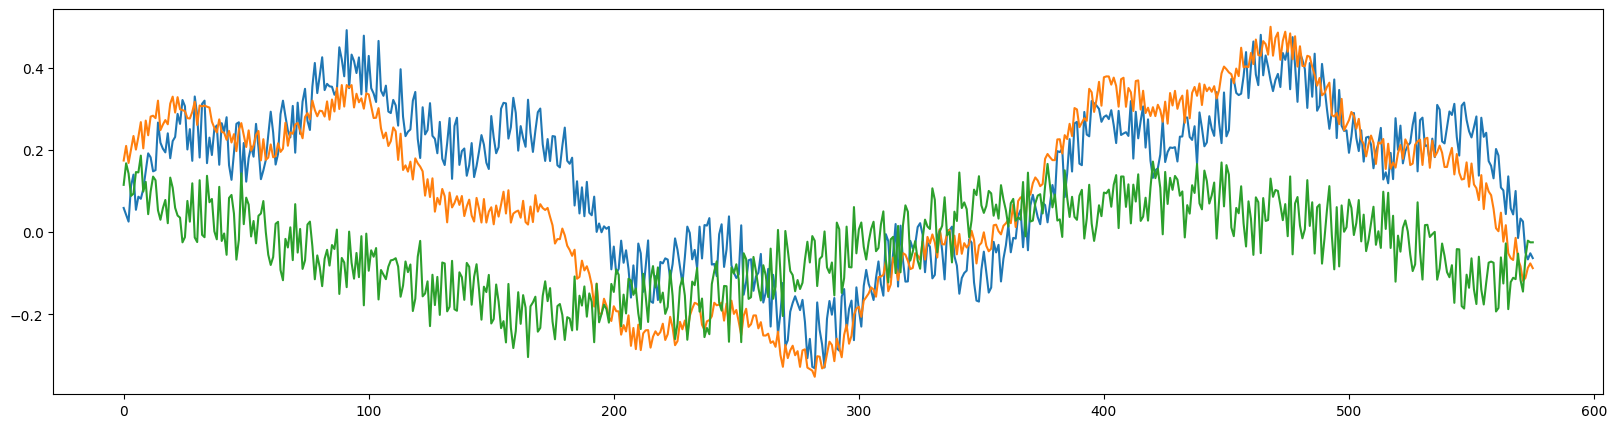

<Figure size 2000x500 with 0 Axes>

In [13]:
interval = 5 # in mins
lenght = 48 # lenght in hours
granulity = 60 / interval# per hour
batInit = 0
xx = []

cons1, prod1 = generate(granulity,lenght,plot=True)

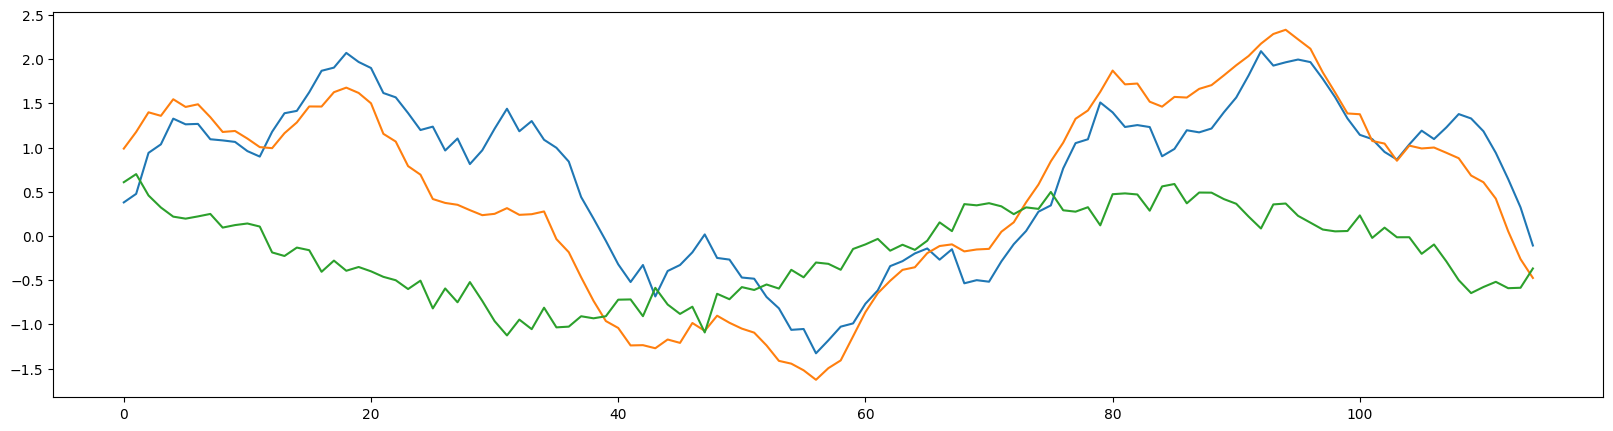

In [15]:
agregAmount = 5
cons,prod = batch(agregAmount,cons1,prod1,plot=True)

## Naive aproach

In [6]:
def naiveAproach(cons,prod,maxBatCap):
    l = len(prod)
    bat = [0]*(l+1)
    #grid = [0]*(l+1)
    #gridEx = [0]*(l+1)

    batChange = prod - cons

    for i in range(l):
        bat[i+1] = bat[i] + batChange[i]

        if bat[i+1] < 0:
            #grid[i+1] = -bat[i+1] 
            bat[i+1] = 0
        if bat[i+1] > maxBatCap:
            #gridEx[i+1] = bat[i+1] - maxBatCap
            bat[i+1] = maxBatCap

    optimX = np.diff(bat)
    return optimX        

32.934373449927335

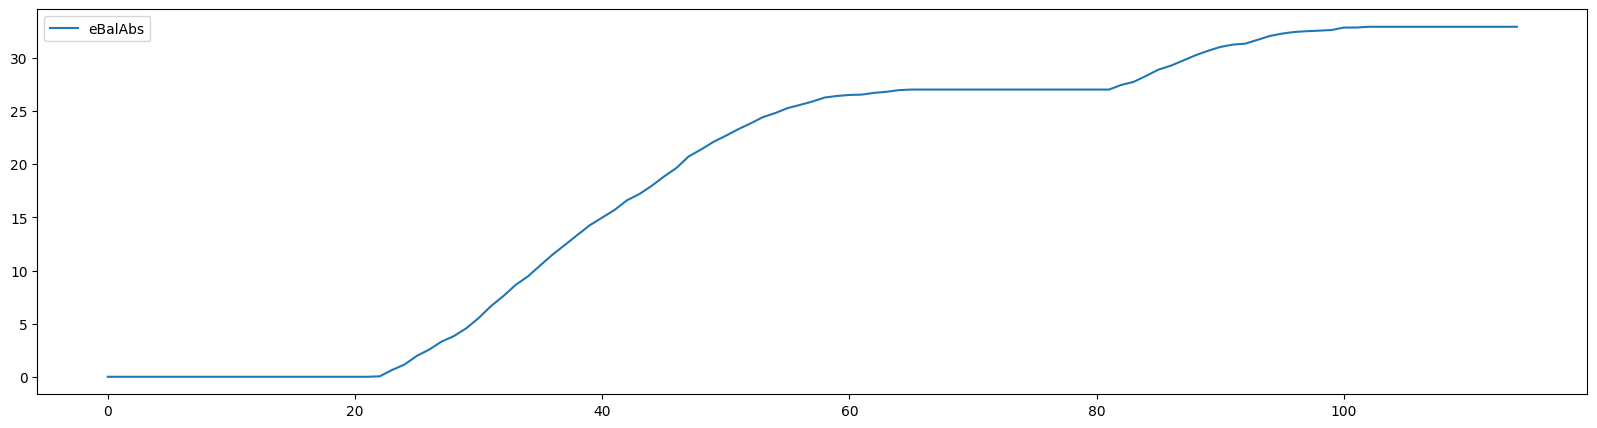

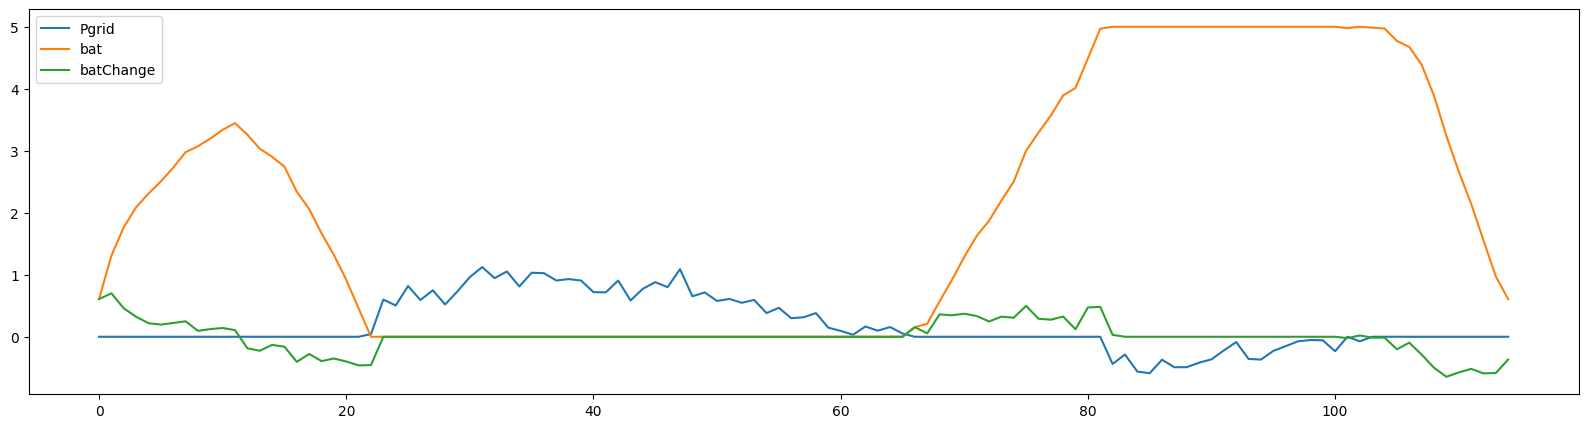

In [16]:
optimX = naiveAproach(cons,prod,maxBatCap=5)
fShow(optimX,cons,prod)

## Power Exchange Optimalization

In [7]:
def powerExchangeOptim(cons,prod,maxBatCap, maxBatChange):
    l = len(prod)
    x = cp.Variable(l)
    bal = cons - prod

    def f(batChange):
        eBalAbs =0
        for i in range(l):
            eBalAbs += cp.abs(bal[i] + batChange[i])
        return eBalAbs

    objective = cp.Minimize(f(x))
    constraints = [-maxBatChange <= x,
                    x <= maxBatChange,
                    cp.max(cp.cumsum(x)) <= maxBatCap,
                    cp.min(cp.cumsum(x)) >= 0]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    #print(x.value)
    #print(constraints[0].dual_value)
    return x.value


33.966603087959776

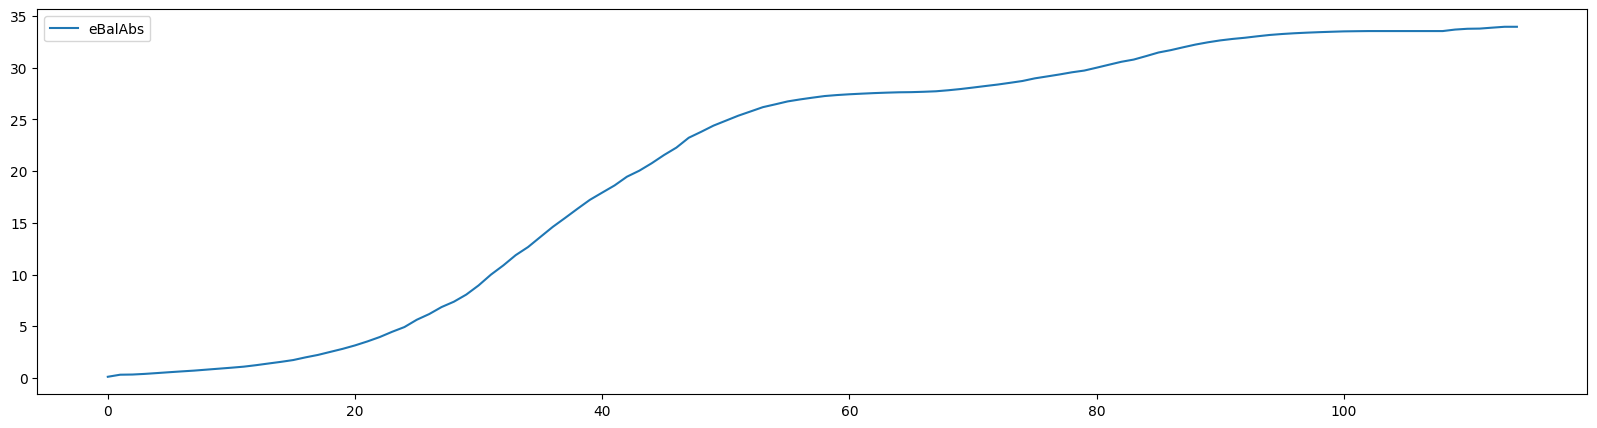

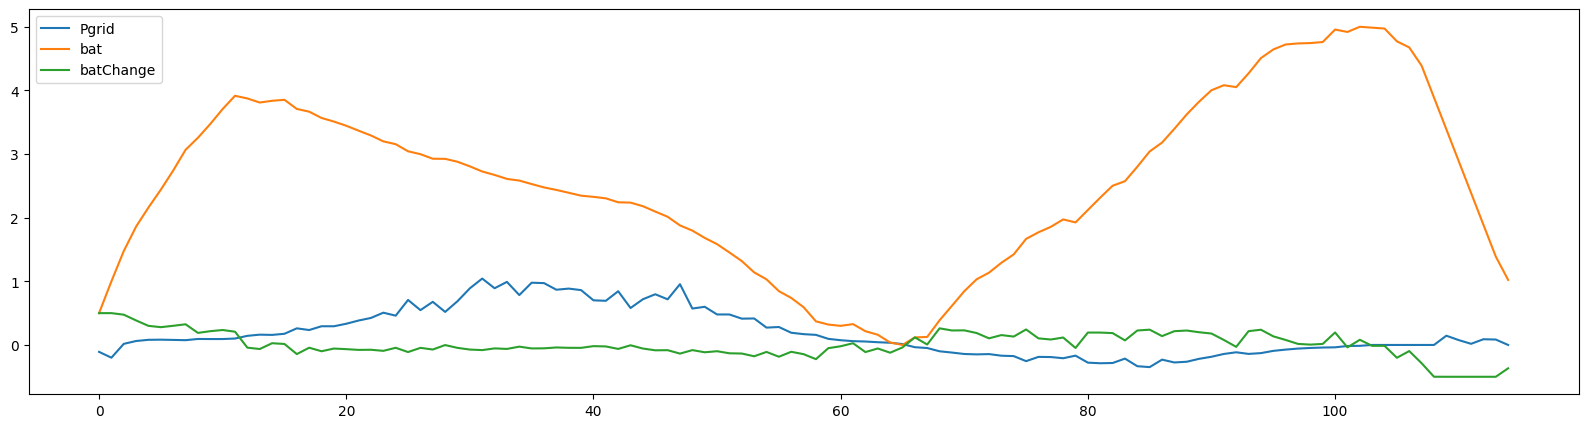

In [17]:
maxBatChange = 0.5
maxBatCap = 5
x = powerExchangeOptim(cons,prod,maxBatCap,maxBatChange)
fShow(x,cons,prod)

## Cost Optimalization

In [9]:
price = [0.5, 1]
def energyCost(i):
    i /= granulity
    i %= 24
    v = (0 <= i <=6) or (13 <= i <=15) or (22 <= i <= 24)
    return v*price[0] + (1-v)* price[1]

def energyCostNP(i):
    ii = i / granulity
    ii %= 24
    return np.where(((0<=ii) & (ii<=6)) | ((13<=ii) & (ii<=15)) | ((22<=ii) & (ii<=24)),price[0],price[1])

'''
def costOptimalization(cons, prod,maxBatCap, maxBatChange, energySellCoef, batChargCoef):
    l = len(prod)
    dis = cp.Variable(l)
    chg = cp.Variable(l)
    bal = cons - prod
    imp = np.maximum(bal,0)
    exp = -np.minimum(bal,0)

    def f(dis,chg):
        cost = 0
        for i in range(l):
            Pimp = imp[i] - dis[i]*batChargCoef
            Pexp = (exp[i] - chg[i])*energySellCoef
            cost += (Pimp - Pexp)*energyCost(i)/granulity*agregAmount
        return cost

    objective = cp.Minimize(f(dis,chg))
    constraints = [0 <= dis, dis <= maxBatChange,
                    0 <= chg, chg <= maxBatChange,
                    cp.min(imp - cp.cumsum(dis)*batChargCoef) >= 0,
                    cp.min(exp - cp.cumsum(chg)) >= 0,
                    cp.min(cp.cumsum(chg - dis)) >= 0,
                    cp.max(cp.cumsum(chg - dis)) <= maxBatCap]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    #print(x.value)
    #print(constraints[0].dual_value)
    return chg.value, dis.value  
'''
1

1

In [19]:
def costOptimalization(cons, prod,maxBatCap, maxBatChange, energySellCoef, batChargCoef):
    l = len(prod)
    dis = cp.Variable(l)
    chg = cp.Variable(l)
    bal = cons - prod
    imp = np.maximum(bal,0) #import do domu (+)
    exp = -np.minimum(bal,0) # export z domu nadwyzka produkcji (+)

    def f(dis,chg): # (+) (+)
        cost = 0
        for i in range(l):
            Pimp = imp[i] - dis[i] # optymalny import (+)
            Pexp = exp[i] - chg[i] # optylmany Export (+)
            cost += Pimp*energyCost(i)/granulity*agregAmount # optymalna import do domu * cena w tej godzinie
            cost -= Pexp*energyCost(i)/granulity*agregAmount*energySellCoef # optymalna export z domu * cena w tej godzinie * 0.8
        return cost

    objective = cp.Minimize(f(dis,chg))
    constraints = [0 <= dis, dis <= maxBatChange,
                    0 <= chg, chg <= maxBatChange,
                    (imp - dis) >= 0,
                    (exp - chg) >= 0,
                    cp.min(cp.cumsum(chg*batChargCoef - dis)) >= 0,
                    cp.max(cp.cumsum(chg*batChargCoef - dis)) <= maxBatCap]
    prob = cp.Problem(objective, constraints)

    result = prob.solve()
    #print(x.value)
    #print(constraints[0].dual_value)
    return chg.value, dis.value

In [85]:
def f(x,y):
    return x + y
a = np.arange(10)
list(map(f,a,[10]*10))


[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

3.3441758054206296

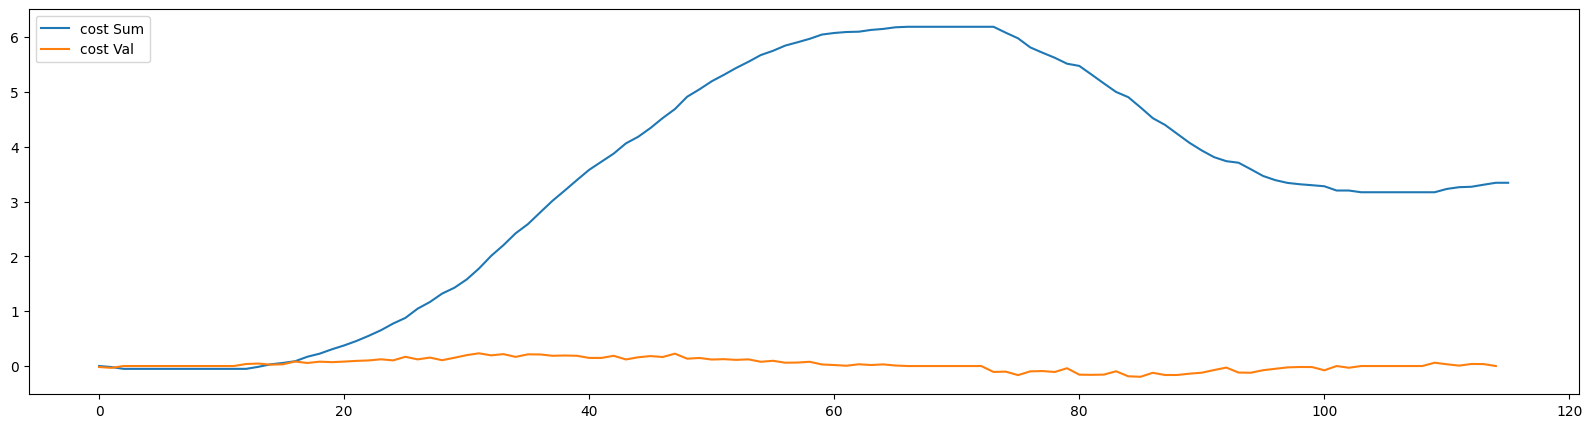

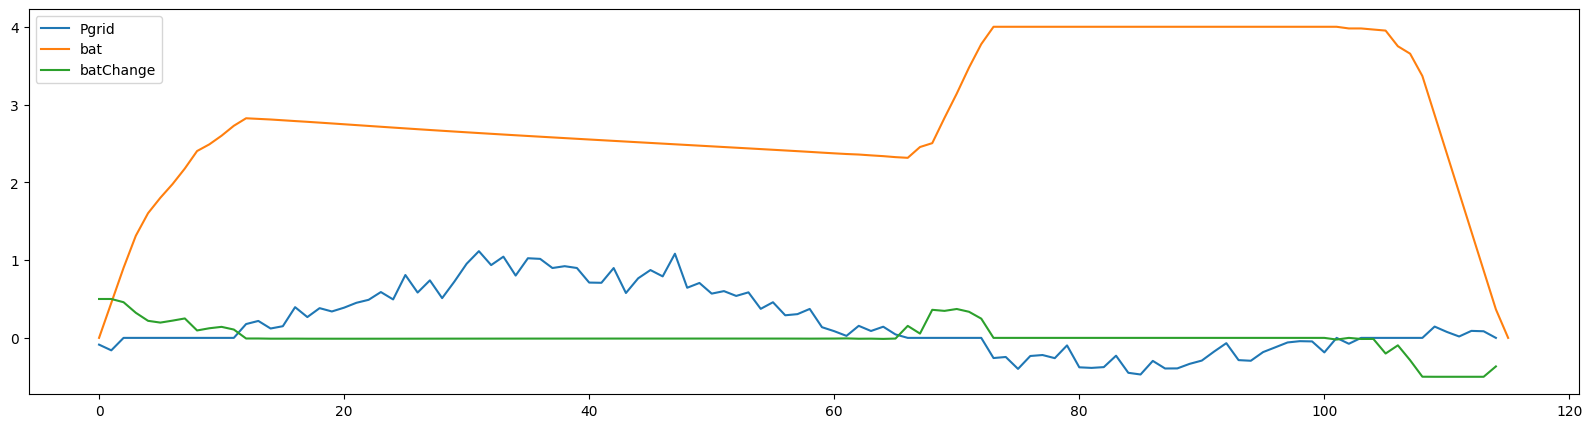

In [21]:
maxBatChange = 0.5
maxBatCap = 5
energySellCoef = 0.8
chg,dis = costOptimalization(cons,prod,maxBatCap,maxBatChange,energySellCoef,batChargCoef=0.9)
fCostShow(chg-dis,cons,prod,0.9)

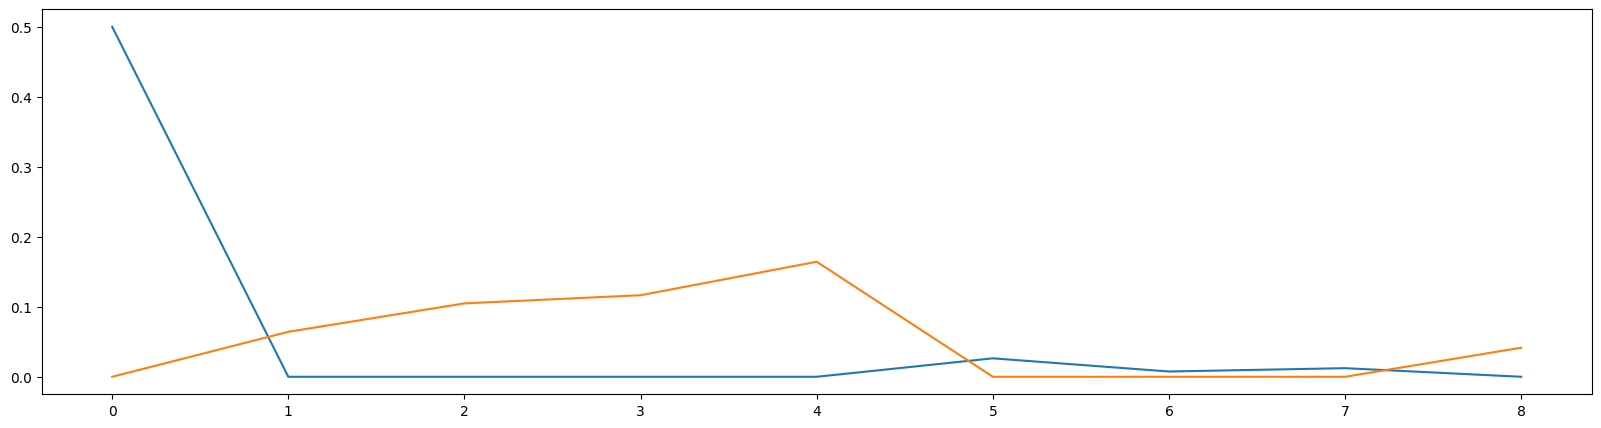

In [12]:
plt.plot(chg)
plt.plot(dis)

3.366819362914018

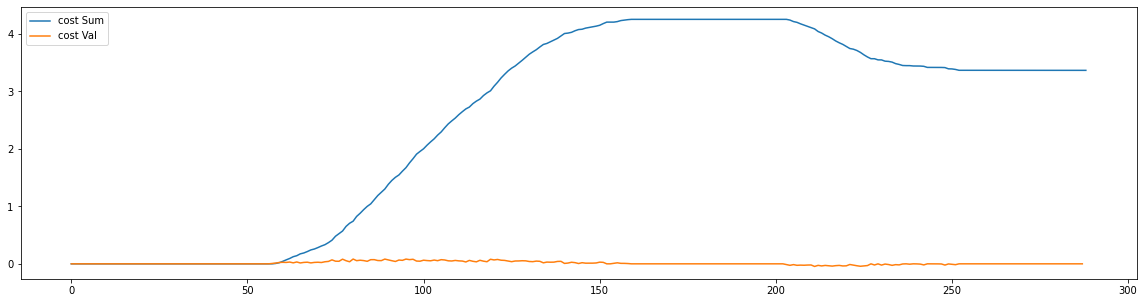

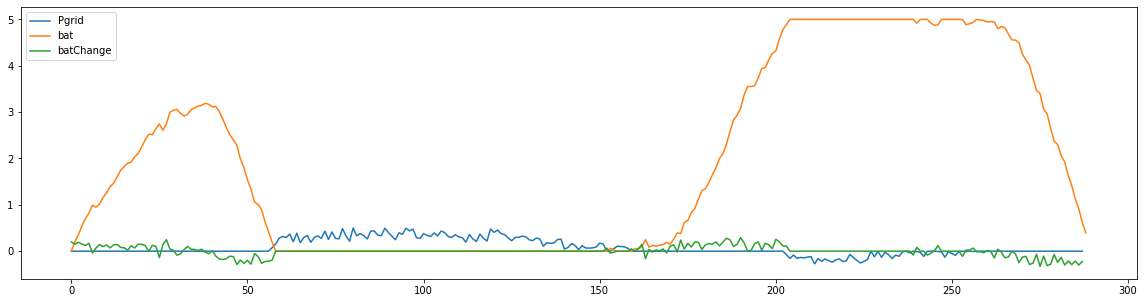

In [121]:
fCostShow(optimX,cons,prod)

## Test for agregation len

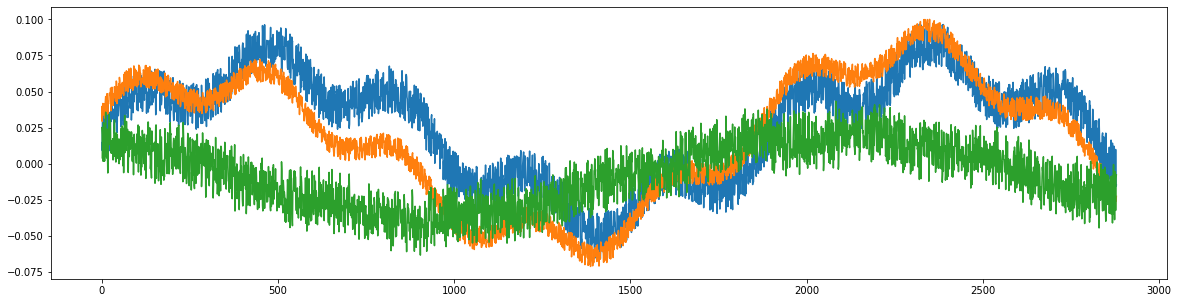

<Figure size 1440x360 with 0 Axes>

In [45]:
interval = 1 # in mins
lenght = 48 # lenght in hours
granulity = 60 / interval# per hour
batInit = 0
cons1, prod1 = generate(granulity,lenght,True)


In [156]:

xNaive = []; xAbsNaive = []
xOpitimzed = []; xAbsOptim = []
xCostOpt = []; xAbsCostOpt = []

maxBatChange = 0.5
maxBatCap = 5
energySellCoef = 0.8
chargeCoef = 0.9

agres = [1,2,3,6,12,24,30,40,50,60,70,80,90,100,110,120]
for i,agregAmount in enumerate(agres):
    cons,prod = batch(agregAmount,cons1,prod1)
    x = naiveAproach(cons,prod,maxBatCap)
    xNaive.append(x)
    xAbsNaive.append(fShow(x,cons,prod,False))
    progres_bar(i*3+1,len(agres)*3)

    x = powerExchangeOptim(cons,prod,maxBatCap,maxBatChange)
    xOpitimzed.append(x)
    xAbsOptim.append(fShow(x,cons,prod,False))
    progres_bar(i*3+2,len(agres)*3)

    chg,dis = costOptimalization(cons,prod,maxBatCap, maxBatChange, energySellCoef, chargeCoef)
    xCostOpt.append(chg-dis)
    xAbsCostOpt.append(fCostShow(xCostOpt[-1],cons,prod, chargeCoef,False))
    progres_bar(i*3+3,len(agres)*3)


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


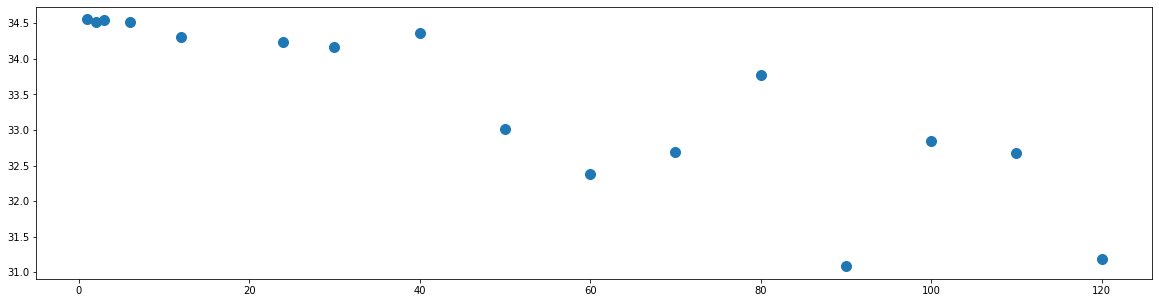

In [157]:
plt.plot(agres, xAbsNaive, "o", markersize=10)

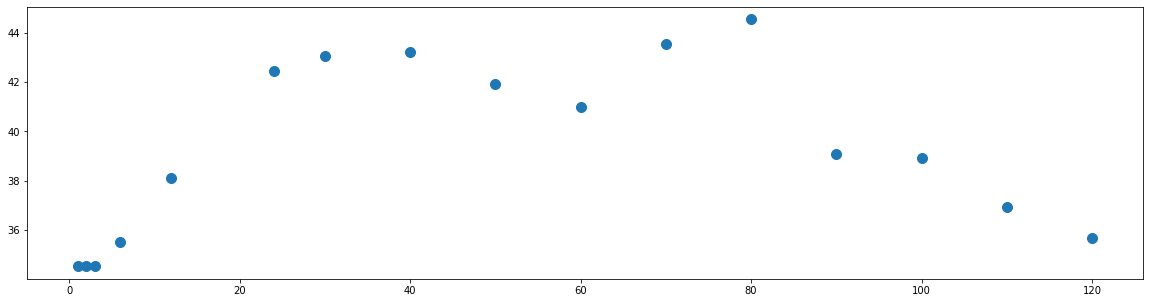

In [158]:
plt.plot(agres, xAbsOptim, "o", markersize=10)

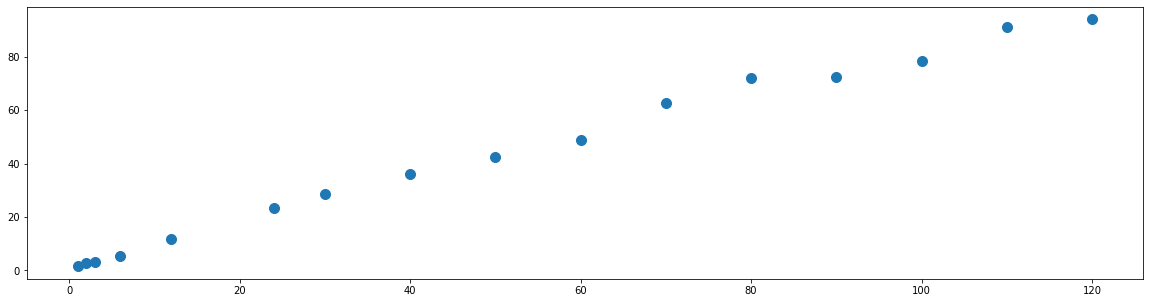

In [159]:

plt.plot(agres, xAbsCostOpt, "o", markersize=10)

In [14]:
import winsound
winsound.Beep(1000, 400)

## Other

In [192]:
bat = batInit - cons.cumsum() + prod.cumsum()

In [156]:
# Problem data.
m = 30
n = 20
np.random.seed(1)
A = np.random.randn(m, n)
b = np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

[-1.79109255e-19  2.85112420e-02  2.79973443e-19  3.37658729e-20
 -2.72802663e-19  1.49285011e-01 -9.94082533e-20  8.35373900e-20
  2.46718649e-01  5.78224144e-01 -4.03739463e-19  1.01242860e-03
 -9.28486180e-20  2.26767464e-01 -1.58813678e-19 -8.97232272e-20
 -1.22145729e-19 -1.51509428e-19  1.12060672e-19 -3.48318635e-19]
[ 2.50938945  0.          2.78354615  1.79425782 13.08579183  0.
  0.73716363  3.35344995  0.          0.          8.93825054  0.
  7.02955161  0.          4.71068649  3.18873635  2.06090107 10.08166738
  3.0481157   8.53268239]


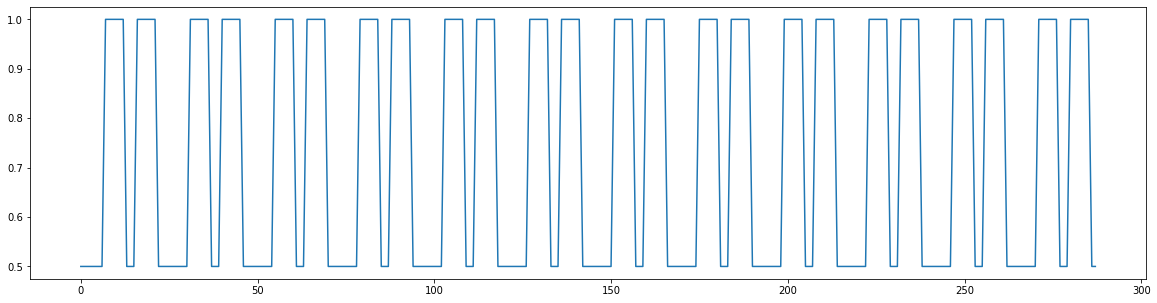

In [205]:
plt.plot(energyCostNP(np.arange(l)))

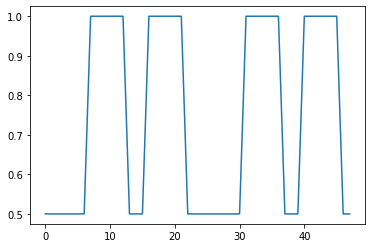

In [127]:
a = [0]*48
for i in range(48):
    a[i]=ePrice(i)
plt.plot(a)


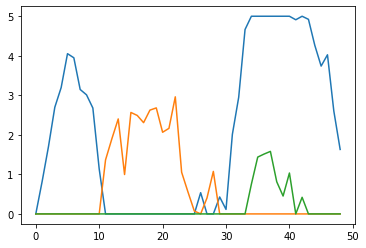

In [119]:
plt.plot(bat)
plt.plot(grid)
plt.plot(gridEx)

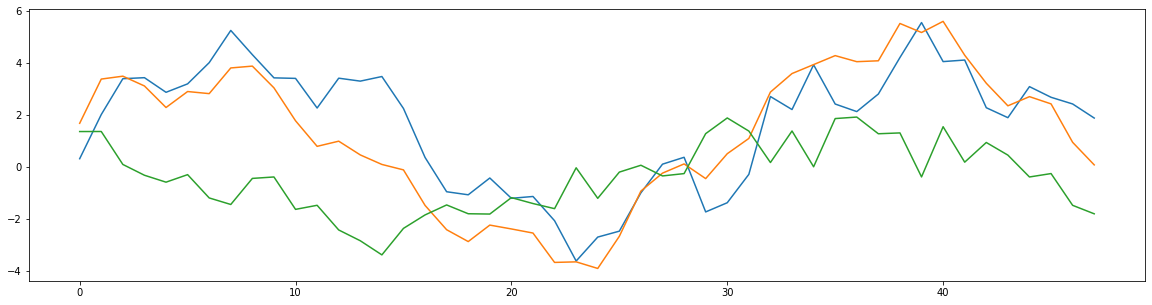

In [184]:
plt.plot(cons)
plt.plot(prod)
plt.plot(prod-cons)